In [2]:
import nltk
from nltk.tokenize import word_tokenize
import matplotlib
%matplotlib inline

from nltk.tag import DefaultTagger
from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

import corus
import pandas as pd
import numpy as np

import pyconll

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
pre_path = '/content/drive/MyDrive/'

full_train = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-train-a.conllu')
full_train_b = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-train-b.conllu')
full_train_c = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-train-c.conllu')

full_train.extend([*full_train_b, *full_train_c]) # объединяем

full_test = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-dev.conllu')

In [9]:
fdata_train = []
for sent in full_train[:]:
    fdata_train.append([(token.form, token.upos) for token in sent])
    
fdata_test = []
for sent in full_test[:]:
    fdata_test.append([(token.form, token.upos) for token in sent])
    
fdata_sent_test = []
for sent in full_test[:]:
    fdata_sent_test.append([token.form for token in sent])

In [10]:
comparing_list = []

### Default tagger

In [11]:
%%time

default_tagger = DefaultTagger('NOUN')

# display(default_tagger.tag(fdata_sent_test[100]))
display(default_tagger.evaluate(fdata_test))

comparing_list.append(('default_tagger', default_tagger.evaluate(fdata_test)))

0.23593983983332248

CPU times: user 347 ms, sys: 21.1 ms, total: 368 ms
Wall time: 369 ms


### Unigram Tagger

In [12]:
%%time

unigram_tagger = UnigramTagger(fdata_train)

# display(unigram_tagger.tag(fdata_sent_test[100]))
display(unigram_tagger.evaluate(fdata_test))

comparing_list.append(('unigram_tagger', unigram_tagger.evaluate(fdata_test)))

0.8782863467673677

CPU times: user 3.9 s, sys: 57.3 ms, total: 3.96 s
Wall time: 3.97 s


### Bigram Tagger

In [13]:
%%time

bigram_tagger = BigramTagger(fdata_train, backoff=unigram_tagger)

# display(bigram_tagger.tag(fdata_sent_test[100]))
display(bigram_tagger.evaluate(fdata_test))

comparing_list.append(('bigram_tagger', bigram_tagger.evaluate(fdata_test)))

0.8839768214076438

CPU times: user 7.08 s, sys: 80.4 ms, total: 7.16 s
Wall time: 7.18 s


### Trigram Tagger

In [14]:
%%time

trigram_tagger = TrigramTagger(fdata_train, backoff=bigram_tagger)

# display(trigram_tagger.tag(fdata_sent_test[100]))
display(trigram_tagger.evaluate(fdata_test))

comparing_list.append(('trigram_tagger', trigram_tagger.evaluate(fdata_test)))

0.8830522820496126

CPU times: user 11.4 s, sys: 80.2 ms, total: 11.4 s
Wall time: 11.5 s


### Taggers combination

In [15]:
from nltk.tag import TrigramTagger 

def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff

backoff = DefaultTagger('NOUN')

In [16]:
%%time

tag = backoff_tagger(fdata_train,  
                     [UnigramTagger, BigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('U_B_T', tag.evaluate(fdata_test)))

0.9119799466111075

CPU times: user 20.2 s, sys: 38.8 ms, total: 20.2 s
Wall time: 20.6 s


In [17]:
%%time

tag = backoff_tagger(fdata_train,  
                     [UnigramTagger, BigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('U_B', tag.evaluate(fdata_test)))

0.9118822840028648

CPU times: user 11.3 s, sys: 23.2 ms, total: 11.3 s
Wall time: 11.4 s


In [18]:
%%time

tag = backoff_tagger(fdata_train,  
                     [BigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('B_T', tag.evaluate(fdata_test)))

0.8606680122403803

CPU times: user 17.9 s, sys: 58.5 ms, total: 17.9 s
Wall time: 18 s


In [19]:
%%time

tag = backoff_tagger(fdata_train,  
                     [UnigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('U_T', tag.evaluate(fdata_test)))

0.9119213490461618

CPU times: user 12.4 s, sys: 33.6 ms, total: 12.4 s
Wall time: 12.7 s


In [20]:
train_tok = []
train_label = []
for sent in fdata_train[:]:
    for tok in sent:
        if (tok[0] is None) or (tok[1] is None):
            continue
        train_tok.append(tok[0])
        train_label.append('NO_TAG' if tok[1] is None else tok[1])
        
test_tok = []
test_label = []
for sent in fdata_test[:]:
    for tok in sent:
        if (tok[0] is None) or (tok[1] is None):
            continue
        test_tok.append(tok[0])
        test_label.append('NO_TAG' if tok[1] is None else tok[1])

In [21]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)

In [22]:
test_enc_labels = le.transform(test_label)

### Count Vectorizer

In [23]:
cvtr = CountVectorizer(ngram_range=(1, 3), analyzer='char')

X_train = cvtr.fit_transform(train_tok)
X_test = cvtr.transform(test_tok)

lr = LogisticRegression(random_state=0, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('count_vectorizer', accuracy_score(test_enc_labels, pred)))

0.8514267079732594

### Hashing Vectorizer

In [24]:
hvtr = HashingVectorizer(ngram_range=(1, 3), analyzer='char', n_features=100)

X_train = hvtr.fit_transform(train_tok)
X_test = hvtr.transform(test_tok)

lr = LogisticRegression(random_state=0, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('hashing_vectorizer', accuracy_score(test_enc_labels, pred)))

0.6735626936246535

### Tfidf Vectorizer

In [25]:
tfvtr = TfidfVectorizer(ngram_range=(1, 3), analyzer='char')

X_train = tfvtr.fit_transform(train_tok)
X_test = tfvtr.transform(test_tok)

lr = LogisticRegression(random_state=0, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('tfidf_vectorizer', accuracy_score(test_enc_labels, pred)))

0.8065416598728192

In [26]:
comparing_list

[('default_tagger', 0.23593983983332248),
 ('unigram_tagger', 0.8782863467673677),
 ('bigram_tagger', 0.8839768214076438),
 ('trigram_tagger', 0.8830522820496126),
 ('U_B_T', 0.9119799466111075),
 ('U_B', 0.9118822840028648),
 ('B_T', 0.8606680122403803),
 ('U_T', 0.9119213490461618),
 ('count_vectorizer', 0.8514267079732594),
 ('hashing_vectorizer', 0.6735626936246535),
 ('tfidf_vectorizer', 0.8065416598728192)]

In [27]:
pd.DataFrame(comparing_list, columns=['tagger', 'accuracy']).sort_values(by='accuracy', ascending=False)

,tagger,accuracy
4,U_B_T,0.911980
7,U_T,0.911921
5,U_B,0.911882
2,bigram_tagger,0.883977
3,trigram_tagger,0.883052
1,unigram_tagger,0.878286
6,B_T,0.860668
8,count_vectorizer,0.851427
10,tfidf_vectorizer,0.806542
9,hashing_vectorizer,0.673563


Очевидно default_tagger справился хуже всего, лучше всех комбинированный и в середине векторайзеры.

In [28]:
!wget http://www.labinform.ru/pub/named_entities/collection5.zip

--2022-07-24 10:37:04--  http://www.labinform.ru/pub/named_entities/collection5.zip
Resolving www.labinform.ru (www.labinform.ru)... 95.181.230.181
Connecting to www.labinform.ru (www.labinform.ru)|95.181.230.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1899530 (1.8M) [application/zip]
Saving to: ‘collection5.zip’

collection5.zip     100%[===================>]   1.81M  2.10MB/s    in 0.9s    

2022-07-24 10:37:05 (2.10 MB/s) - ‘collection5.zip’ saved [1899530/1899530]



In [29]:
!unzip collection5.zip

Archive:  collection5.zip
   creating: Collection5/
  inflating: Collection5/001.ann     
  inflating: Collection5/001.txt     
  inflating: Collection5/002.ann     
  inflating: Collection5/002.txt     
  inflating: Collection5/003.ann     
  inflating: Collection5/003.txt     
  inflating: Collection5/004.ann     
  inflating: Collection5/004.txt     
  inflating: Collection5/005.ann     
  inflating: Collection5/005.txt     
  inflating: Collection5/006.ann     
  inflating: Collection5/006.txt     
  inflating: Collection5/007.ann     
  inflating: Collection5/007.txt     
  inflating: Collection5/008.ann     
  inflating: Collection5/008.txt     
  inflating: Collection5/009.ann     
  inflating: Collection5/009.txt     
  inflating: Collection5/010.ann     
  inflating: Collection5/010.txt     
  inflating: Collection5/011.ann     
  inflating: Collection5/011.txt     
  inflating: Collection5/012.ann     
  inflating: Collection5/012.txt     
  inflating: Collection5/013.ann    

In [30]:
from corus import load_ne5

path_coll5 = 'Collection5/'
records = load_ne5(path_coll5)
next(records)

Ne5Markup(
    id='183',
    text='Медведев уволил главу транспортной милиции по Центральному федеральному округу\r\n\r\nПрезидент России Дмитрий Медведев уволил начальника управления на транспорте МВД РФ по Центральному федеральному округу Андрея Алексеева. Об этом сообщает РИА Новости.\r\n\r\nАлексеев был назначен на эту должность самим Медведевым в начале августа 2010 года. До этого он занимал пост начальника Московского УВД на железнодорожном транспорте МВД России. Как отмечала "Комсомольская правда", за время работы в органах внутренних дел Алексеев отличился тем, что обменял себя на троих заложников при нападении террористов на Омский драматический театр. В 1996 году Алексеева наградили за этот поступок Орденом Мужества.\r\n\r\nВ ходе совещания по безопасности на транспорте, которое проходит 26 января в Горках, Дмитрий Медведев также поручил главе МВД Рашиду Нургалиеву "тряхнуть" всю транспортную милицию для обеспечения контроля за безопасностью. Он также отметил необходимость со

In [31]:
from razdel import tokenize

In [32]:
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

In [33]:
df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])

In [34]:
df_words['tag'].value_counts()
df_words.head(3)

,word,tag
0,Ленобласть,LOC
1,:,OUT
2,открыт,OUT


In [35]:
df_words.shape

(265292, 2)

In [36]:
records = load_ne5(path_coll5)
next(records).text
next(records).text
next(records).text
next(records).text
next(records).text
article = next(records).text
article

'Губернаторов семи российских регионов ждет скорая отставка\r\n \r\nГлавы Курганской и Курской областей Олег Богомолов и Александр Михайлов находятся в зоне максимального риска отставки. Много шансов не досидеть до конца срока с недавних пор и у тульского губернатора Вячеслава Дудки, следует из данных рейтинга выживаемости губернаторов, который будет опубликован сегодня. Впрочем, как сообщает РБК daily, в Кремле пока не планируют досрочных отставок.\r\n\r\nСамых худших глав регионов эксперты фонда "Петербургская политика" и холдинга "Минченко консалтинг" вычислили в рамках исследования рейтинга политической выживаемости губернаторов, который подсчитывается уже несколько лет. Как рассказал РБК daily один из авторов исследования, глава фонда "Петербургская политика" Михаил Виноградов, в преддверии выборов обозначились три проблемных центра: Центральная Россия, Урал и Сибирь. Именно там у губернаторов могут возникнуть серьезные проблемы с продлением полномочий.\r\n\r\nВ Центральной России

NLTK

In [37]:
import nltk
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('names')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [38]:
words5 = list(df_words.word)

In [39]:
data5_tag = nltk.pos_tag(words5[:50000])

In [40]:
{(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(article))) if hasattr(chunk, 'label') }

{('Впрочем', 'PERSON'),
 ('Дмитрий Зеленин', 'PERSON'),
 ('Кремле', 'PERSON'),
 ('Кроме', 'PERSON'),
 ('Курской', 'PERSON'),
 ('Леонида Полежаева', 'PERSON'),
 ('Михаил Виноградов', 'PERSON'),
 ('Михайлова', 'PERSON'),
 ('Наталья Комарова', 'PERSON'),
 ('РБК', 'ORGANIZATION'),
 ('Россия', 'PERSON'),
 ('Сибири', 'PERSON'),
 ('Также', 'PERSON'),
 ('Урал', 'PERSON'),
 ('Урале', 'PERSON'),
 ('Центральной России', 'PERSON')}

NLTK справился ужасно))

Spacy

In [41]:
!python -m spacy download ru_core_news_sm

2022-07-24 10:37:41.039421: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 5.0 MB/s 
     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 8.2 MB 10.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [42]:
import spacy
from spacy import displacy

In [43]:
nlp = spacy.load("ru_core_news_sm")
spacy_article = nlp(article)
displacy.render(spacy_article, jupyter=True, style='ent')

Spacy неплохо справился

Deeppaclov

Natasha

In [48]:
!pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.4 MB 169 kB/s 
     |████████████████████████████████| 41 kB 127 kB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=982807a68f65de1e670d20c9f149da893437a8bce53de111677b5d445567b6d1
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [49]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

In [50]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '
doc = Doc(article)

In [51]:
doc.segment(segmenter)
display(doc.tokens[:5])
display(doc.sents[:5])

[DocToken(stop=12, text='Губернаторов'),
 DocToken(start=13, stop=17, text='семи'),
 DocToken(start=18, stop=28, text='российских'),
 DocToken(start=29, stop=37, text='регионов'),
 DocToken(start=38, stop=42, text='ждет')]

[DocSent(stop=181, text='Губернаторов семи российских регионов ждет скорая..., tokens=[...]),
 DocSent(start=182, stop=368, text='Много шансов не досидеть до конца срока с недавни..., tokens=[...]),
 DocSent(start=369, stop=448, text='Впрочем, как сообщает РБК daily, в Кремле пока не..., tokens=[...]),
 DocSent(start=452, stop=674, text='Самых худших глав регионов эксперты фонда "Петерб..., tokens=[...]),
 DocSent(start=675, stop=876, text='Как рассказал РБК daily один из авторов исследова..., tokens=[...])]

In [52]:
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
sent = doc.sents[0]
sent.morph.print()

        Губернаторов NOUN|Animacy=Anim|Case=Acc|Gender=Masc|Number=Plur
                семи NUM|Case=Gen
          российских ADJ|Case=Gen|Degree=Pos|Number=Plur
            регионов NOUN|Animacy=Inan|Case=Gen|Gender=Masc|Number=Plur
                ждет VERB|Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act
              скорая ADJ|Case=Nom|Degree=Pos|Gender=Fem|Number=Sing
            отставка NOUN|Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing
               Главы PROPN|Animacy=Anim|Case=Gen|Gender=Masc|Number=Sing
          Курганской ADJ|Case=Gen|Degree=Pos|Gender=Fem|Number=Sing
                   и CCONJ
             Курской ADJ|Case=Gen|Degree=Pos|Gender=Fem|Number=Sing
            областей NOUN|Animacy=Inan|Case=Gen|Gender=Fem|Number=Plur
                Олег PROPN|Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing
           Богомолов PROPN|Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing
                   и CCONJ
           Александр PROPN|Animacy=Anim|Case=

In [53]:
sent.syntax.print()

┌──────────► Губернаторов  nsubj
│       ┌──► семи          nummod
│       │ ┌► российских    amod
│       └─└─ регионов      
│       ┌─── ждет          
│       │ ┌► скорая        amod
│ ┌─────└►└─ отставка      nsubj
│ │ ┌───└──► Главы         nmod
│ │ │ ┌►┌─── Курганской    amod
│ │ │ │ │ ┌► и             cc
│ │ │ │ └►└─ Курской       conj
│ │ └►└───── областей      nmod
│ └────►┌─┌─ Олег          appos
│       │ └► Богомолов     flat:name
│       │ ┌► и             cc
│       └►└─ Александр     conj
│       └──► Михайлов      flat:name
└───┌───┌─── находятся     
    │   │ ┌► в             case
    │ ┌─└►└─ зоне          obl
    │ │   ┌► максимального amod
    │ └►┌─└─ риска         nmod
    │   └──► отставки      nmod
    └──────► .             punct


In [54]:
doc.tag_ner(ner_tagger)
doc.ner.print()

Губернаторов семи российских регионов ждет скорая отставка
 
Главы Курганской и Курской областей Олег Богомолов и Александр 
      LOC───────   LOC───────────── PER───────────   PER───────
Михайлов находятся в зоне максимального риска отставки. Много шансов 
────────                                                             
не досидеть до конца срока с недавних пор и у тульского губернатора 
Вячеслава Дудки, следует из данных рейтинга выживаемости губернаторов,
PER────────────                                                       
 который будет опубликован сегодня. Впрочем, как сообщает РБК daily, в
                                                          ORG──────   
 Кремле пока не планируют досрочных отставок.
 LOC───                                      
Самых худших глав регионов эксперты фонда "Петербургская политика" и 
                                           ORG───────────────────    
холдинга "Минченко консалтинг" вычислили в рамках исследования 
          ORG─────────

Natasha справилась тоже довольно неплохо

## Создадим свой NER


In [55]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, GRU, LSTM, Dropout, Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [56]:
from sklearn import model_selection, preprocessing, linear_model

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_words['word'], df_words['tag'])

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [57]:
train_x.apply(len).max(axis=0)

32

In [58]:
# char level
#train_x = train_x.apply(lambda x: ' '.join(list(x)))
#valid_x = valid_x.apply(lambda x: ' '.join(list(x)))

In [59]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [60]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

### Униграмы

In [61]:
def custom_standardization(input_data):
    return input_data

vocab_size = 30000
seq_len = 10

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    #ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [62]:
len(vectorize_layer.get_vocabulary())

29925

In [63]:
embedding_dim = 64

class modelNER(tf.keras.Model):
    def __init__(self):
        super(modelNER, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gPool = GlobalMaxPooling1D()
        self.fc1 = Dense(300, activation='relu')
        self.fc2 = Dense(50, activation='relu')
        self.fc3 = Dense(6, activation='softmax')

    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        pool_x = self.gPool(x)
        
        fc_x = self.fc1(pool_x)
        fc_x = self.fc2(fc_x)
        
        concat_x = tf.concat([pool_x, fc_x], axis=1)
        prob = self.fc3(concat_x)
        return prob

In [64]:
mmodel = modelNER()

In [65]:
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [66]:
mmodel.fit(train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12436/12436 [==============================] - 259s 21ms/step - loss: 0.2924 - accuracy: 0.9147 - val_loss: 0.2112 - val_accuracy: 0.9372
Epoch 2/3
12436/12436 [==============================] - 215s 17ms/step - loss: 0.1249 - accuracy: 0.9625 - val_loss: 0.2095 - val_accuracy: 0.9410
Epoch 3/3
12436/12436 [==============================] - 198s 16ms/step - loss: 0.1090 - accuracy: 0.9655 - val_loss: 0.2136 - val_accuracy: 0.9416


In [67]:
preds = mmodel.predict(valid_x)
preds = np.argmax(preds,axis=1)

In [68]:
print(classification_report(valid_y, preds))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1175
           1       0.86      0.81      0.84      1143
           2       0.95      0.78      0.85       595
           3       0.90      0.55      0.68      3367
           4       0.94      1.00      0.97     54688
           5       0.99      0.70      0.82      5355

    accuracy                           0.94     66323
   macro avg       0.92      0.79      0.84     66323
weighted avg       0.94      0.94      0.94     66323



In [69]:
classes = encoder.classes_
classes

array(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'], dtype=object)

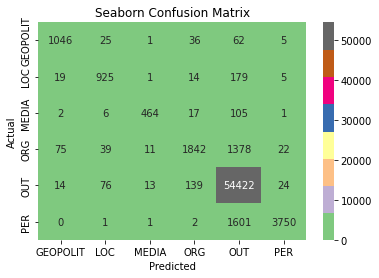

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(valid_y, preds)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

### Изменим векторайзер, добавив биграмы

In [71]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 2),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
mmodel_bi = modelNER()
mmodel_bi.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mmodel_bi.fit( train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12436/12436 [==============================] - 233s 19ms/step - loss: 0.2946 - accuracy: 0.9141 - val_loss: 0.2065 - val_accuracy: 0.9380
Epoch 2/3
12436/12436 [==============================] - 232s 19ms/step - loss: 0.1247 - accuracy: 0.9628 - val_loss: 0.2548 - val_accuracy: 0.8954
Epoch 3/3
12436/12436 [==============================] - 233s 19ms/step - loss: 0.1089 - accuracy: 0.9655 - val_loss: 0.2149 - val_accuracy: 0.9407


              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1175
           1       0.86      0.81      0.83      1143
           2       0.95      0.78      0.85       595
           3       0.90      0.54      0.67      3367
           4       0.94      0.99      0.97     54688
           5       0.99      0.70      0.82      5355

    accuracy                           0.94     66323
   macro avg       0.92      0.78      0.84     66323
weighted avg       0.94      0.94      0.94     66323



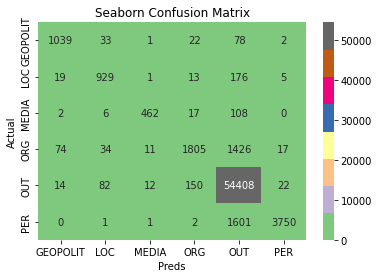

In [72]:
preds_bi = mmodel_bi.predict(valid_x)
preds_bi = np.argmax(preds_bi,axis=1)

print(classification_report(valid_y, preds_bi))

cm = confusion_matrix(valid_y, preds_bi)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Preds')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

### Изменим векторайзер, добавив биграмы и триграмы, и длину последовательности 100.


In [73]:
seq_len = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
mmodel_three = modelNER()
mmodel_three.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mmodel_three.fit( train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12436/12436 [==============================] - 235s 19ms/step - loss: 0.2938 - accuracy: 0.9145 - val_loss: 0.2079 - val_accuracy: 0.9378
Epoch 2/3
12436/12436 [==============================] - 234s 19ms/step - loss: 0.1251 - accuracy: 0.9628 - val_loss: 0.2740 - val_accuracy: 0.8958
Epoch 3/3
12436/12436 [==============================] - 241s 19ms/step - loss: 0.1092 - accuracy: 0.9655 - val_loss: 0.2092 - val_accuracy: 0.9409


              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1175
           1       0.87      0.81      0.84      1143
           2       0.95      0.77      0.85       595
           3       0.91      0.53      0.67      3367
           4       0.94      1.00      0.97     54688
           5       0.98      0.70      0.82      5355

    accuracy                           0.94     66323
   macro avg       0.93      0.78      0.84     66323
weighted avg       0.94      0.94      0.94     66323



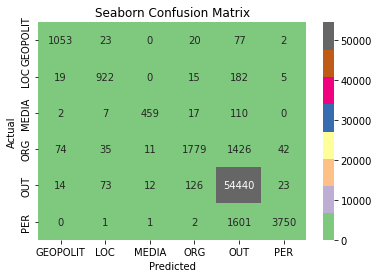

In [74]:
preds_three = mmodel_three.predict(valid_x)
preds_three = np.argmax(preds_three,axis=1)

print(classification_report(valid_y, preds_three))

cm = confusion_matrix(valid_y, preds_three)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

Самописная NER в принципе неплохо справляется. Есть небольшое улучшение, когда даем сетке токен и соседей, по сравнению с тем, когда даем сетке только токен.